# HALO UNIFIED dataset

The HALO UNIFEID dataset is a combination of [HAMP](https://amt.copernicus.org/articles/7/4539/2014/) radar and radiometer measurements, [BAHAMAS](http://www.halo.dlr.de/instrumentation/basis.html) aircraft position data and [dropsonde](https://github.com/Geet-George/JOANNE#joanne---the-eurec4a-dropsonde-dataset) measurements, all on a unified temporal and spatial grid. 

More information on the dataset can be found at {cite:t}`Konow:2021`. If you have questions or if you would like to use the data for a publication, please don't hesitate to get in contact with the dataset authors as stated in the dataset attributes `contact` or `author`.

## Get data
* To load the data we first load the EUREC4A meta data catalogue. More information on the catalog can be found [here](https://github.com/eurec4a/eurec4a-intake#eurec4a-intake-catalogue).

In [1]:
import eurec4a

In [2]:
cat = eurec4a.get_intake_catalog(use_ipfs="QmahMN2wgPauHYkkiTGoG2TpPBmj3p5FoYJAq9uE9iXT9N")
list(cat.HALO.UNIFIED)

['BAHAMAS',
 'HAMPradar',
 'HAMPradar_cloudmask',
 'HAMPradiometer',
 'HAMPradiometer_cloudmask',
 'HAMPradiometer_retrievals',
 'dropsondes']

* We can further specify an instrument and a flight and obtain the dataset using `to_dask`.

```{note}
Have a look at the attributes of the xarray dataset `ds` for all relevant information on the dataset, such as author, contact, or citation infromation.
```

In [3]:
ds_radar = cat.HALO.UNIFIED.HAMPradar["HALO-0205"].to_dask()
ds_radiometer = cat.HALO.UNIFIED.HAMPradiometer["HALO-0205"].to_dask()
ds_bahamas = cat.HALO.UNIFIED.BAHAMAS["HALO-0205"].to_dask()

## Load HALO flight phase information
All HALO flights were split up into flight phases or segments to allow for a precise selection in time and space of a circle or calibration pattern. For more information have a look at the respective [github repository](https://github.com/eurec4a/halo-flight-phase-separation).

In [4]:
meta = eurec4a.get_flight_segments()

We select the flight phase we are interested in, e.g. the second circle on February 5 by it’s segment_id.

In [5]:
segments = {s["segment_id"]: {**s, "flight_id": flight["flight_id"]}
             for platform in meta.values()
             for flight in platform.values()
             for s in flight["segments"]
            }
seg = segments["HALO-0205_c2"]

We transfer the information from our flight segment selection to our radar and radiometer data in the xarray dataset.

In [6]:
ds_radar_selection = ds_radar.sel(time=slice(seg["start"], seg["end"]))
ds_radiometer_selection = ds_radiometer.sel(time=slice(seg["start"], seg["end"]))
ds_bahamas_selection = ds_bahamas.sel(time=slice(seg["start"], seg["end"]))

## Plots

We plot reflectivity from the HAMP Radar, the flight altitude of HALO and brightness temperatures from the low-frequency channels along the 22 GHz water vapor line (K band) from the HAMP radiometer.

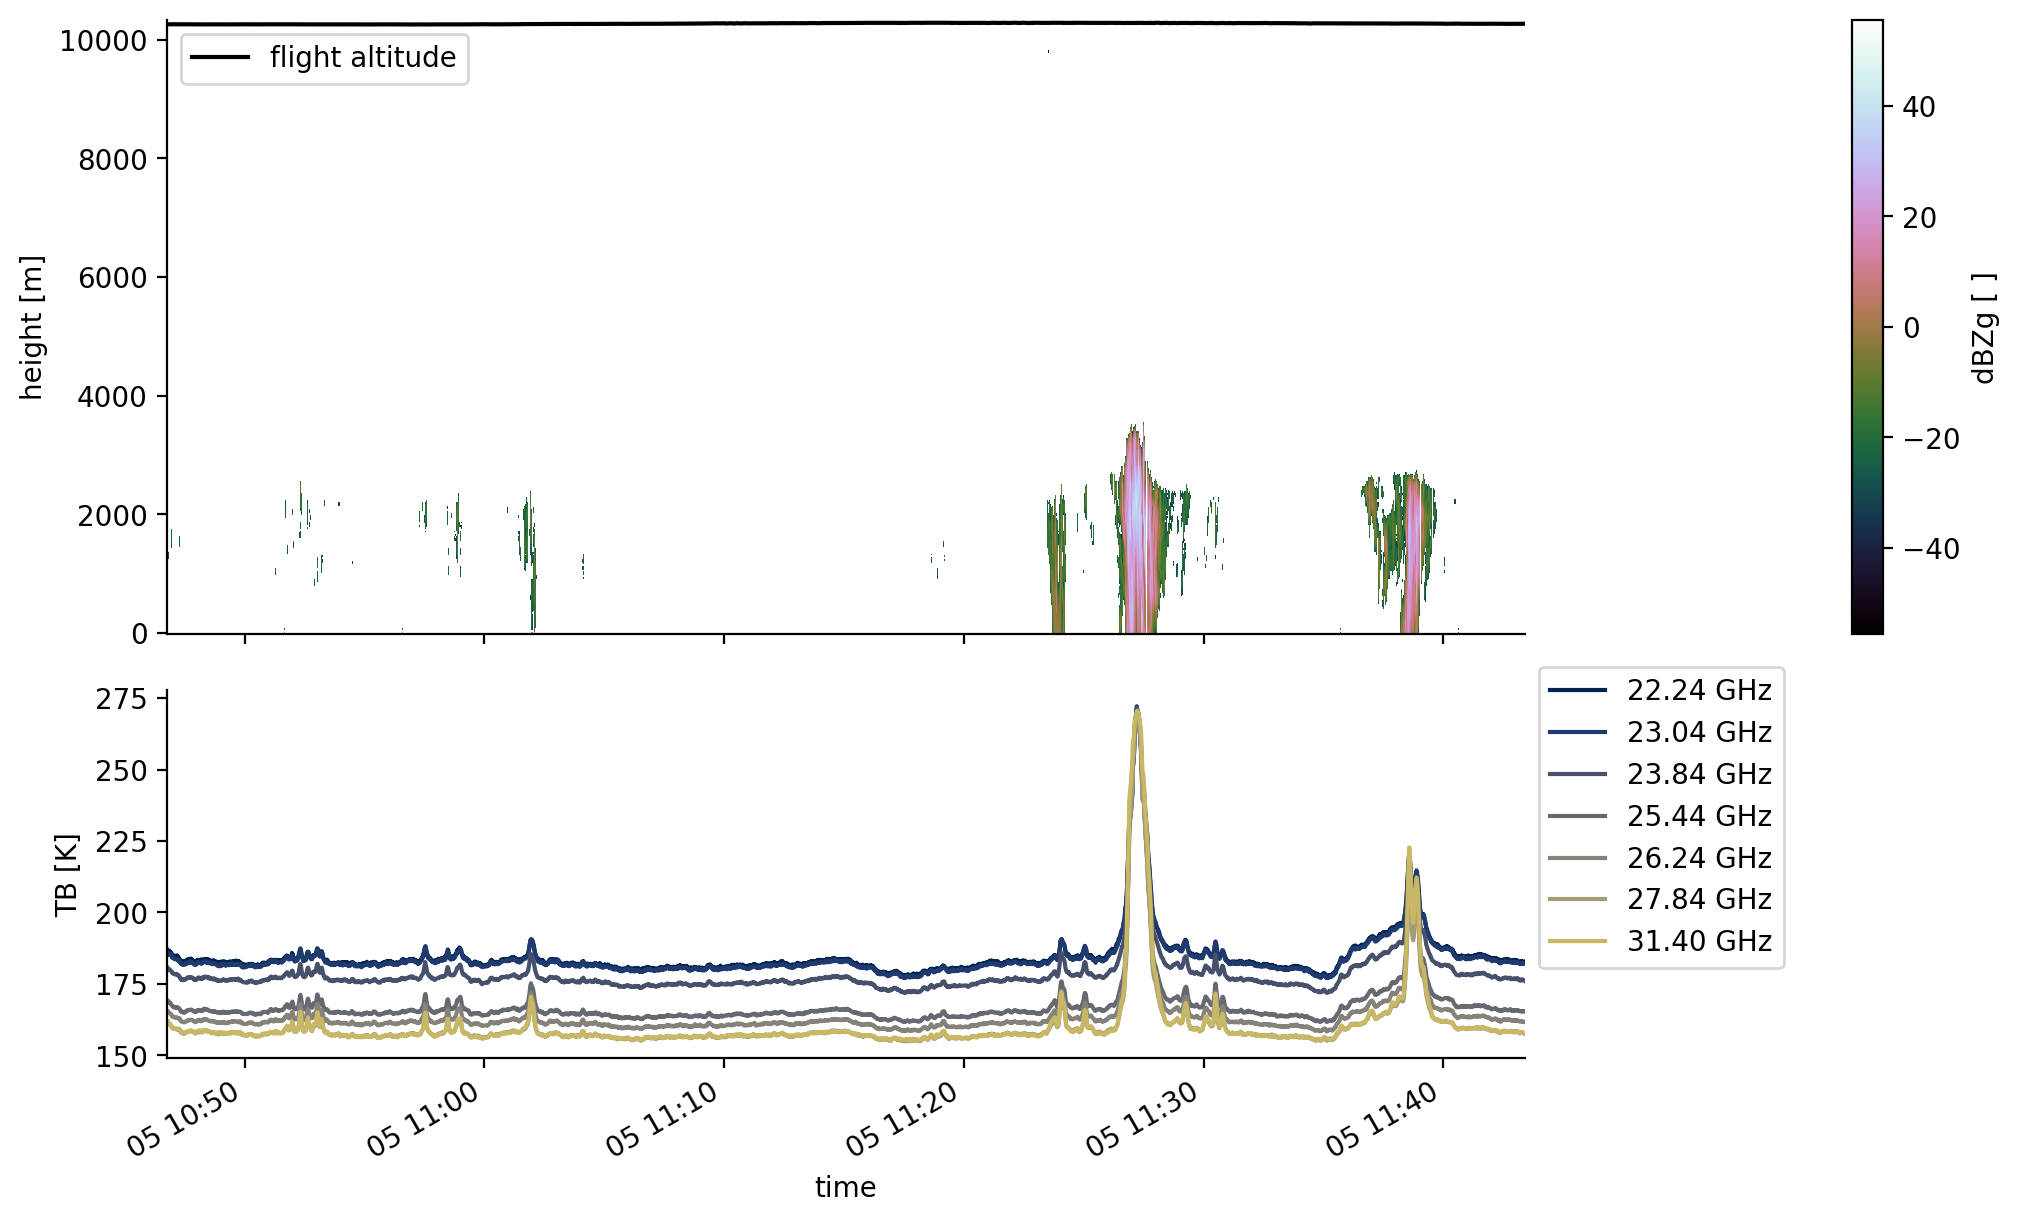

In [7]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("./mplstyle/book")

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, gridspec_kw={'height_ratios':(2, 1.2)})

# 1st plot: Radar dBZ and flight altitude
ds_bahamas_selection.altitude.plot(ax=ax1, x='time', color='black', label='flight altitude')
ax1.legend(loc ='upper left')
ds_radar_selection.dBZ.plot(ax=ax1, x='time', cmap='cubehelix' )
ax1.set_xlabel('')

# 2nd plot: Radiometer TB
## select low frequency channels along the 22 GHz water vapor line
low_freq = ds_radiometer_selection.frequency < 32
ds_radiometer_low_freq = ds_radiometer_selection.isel(frequency=low_freq)
## set line colors for 2nd plot
colors2 = plt.get_cmap("cividis")(np.linspace(0, 0.8, low_freq.values.sum()))
ax2.set_prop_cycle(color=colors2)
for frequency, data_radiometer in ds_radiometer_low_freq.groupby("frequency"):
    data_radiometer.tb.plot(ax=ax2, x='time', label=f'{frequency:.2f} GHz')
ax2.set_title('')
ax2.legend(bbox_to_anchor=(1,1.1))
None